In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, LongType
from pyspark.sql.functions import split, explode, sum, lit, col, when, asc, desc, avg, mean, count, isnan

spark = SparkSession.builder.master('local[1]').appName('big_data').config('spark.driver.extraJavaOptions', '-Xss3g').getOrCreate()

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

path = 'path_to_movies.csv'

users_who_rate = spark.read \
    .option('header', True) \
    .option('inferschema', True) \
    .schema(StructType([
        StructField('Movie_ID', LongType(), True),
        StructField('Name', StringType(), True),
        StructField('Year', LongType(), True),
        StructField('User_ID', LongType(), True),
        StructField('Rating', DoubleType(), True),
    ])) \
    .csv(path)

In [4]:
# Checking if is there a NaN or null value in user rating
users_who_rate.select([count(when(isnan('Rating') | col('Rating').isNull(), 'Rating'))])

count(CASE WHEN (isnan(Rating) OR (Rating IS NULL)) THEN Rating END)
0


In [5]:
# Checking if is there a NaN or null value in movie id
users_who_rate.select([count(when(isnan('Movie_ID') | col('Movie_ID').isNull(), 'Movie_ID'))])

count(CASE WHEN (isnan(Movie_ID) OR (Movie_ID IS NULL)) THEN Movie_ID END)
0


In [6]:
# Checking if is there a NaN or null value in user id
users_who_rate.select([count(when(isnan('User_ID') | col('User_ID').isNull(), 'User_ID'))])

count(CASE WHEN (isnan(User_ID) OR (User_ID IS NULL)) THEN User_ID END)
0


In [7]:
# Columns informations
users_who_rate.printSchema()

print()

users_who_rate.show(200, truncate = True)

# Count the number of unique movie IDs
unique_movie_count = users_who_rate.select("Movie_ID").distinct().count()

# users rates total row count
print('User rates total row count: ', users_who_rate.count())

print()

# Print the unique movie number result
print("Number of Unique Movie ID: ", unique_movie_count, "\n")

print()

# users rates mathematical information table
users_who_rate.select('Rating').describe()

root
 |-- Movie_ID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- User_ID: long (nullable = true)
 |-- Rating: double (nullable = true)


+--------+--------------------+----+-------+------+
|Movie_ID|                Name|Year|User_ID|Rating|
+--------+--------------------+----+-------+------+
|    1756|Murder on the Ori...|1974|      6|   3.0|
|     175|      Reservoir Dogs|1992|      6|   5.0|
|     241|  North by Northwest|1959|      6|   3.0|
|    1765|           First Kid|1996|      6|   3.0|
|     886|                 Ray|2004|      6|   5.0|
|    1798|       Lethal Weapon|1987|      6|   3.0|
|    1799|Die Hard 2: Die H...|1990|      6|   3.0|
|     468|The Matrix: Revol...|2003|      6|   3.0|
|     985|           The Mummy|1999|      6|   4.0|
|    1803|Alien: Resurrecti...|1997|      6|   3.0|
|    3905|          The Others|2001|      6|   3.0|
|    1832|     Rosemary's Baby|1968|      6|   3.0|
|    1096|       Harlem Nights

summary,Rating
count,100000
mean,3.61908
stddev,1.0588725918219113
min,1.0
max,5.0


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

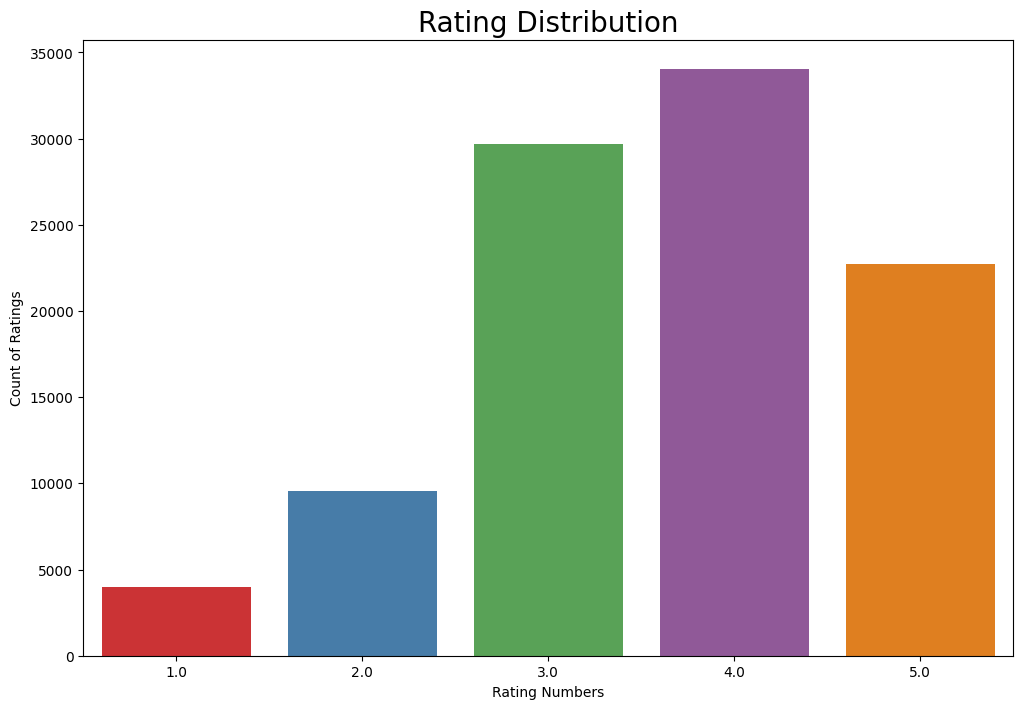

In [9]:
# Rating distribution and group by user rating and count the number of user ratings
# By using orderBy('Rating') after the groupby operation, the resulting DataFrame is sorted in... 
#...ascending order based on the 'Rating' column.

rating_distribution = users_who_rate.groupby('Rating').count().orderBy('Rating')

# Convert pyspark data frame to pandas data frame for plotting with seaborn
rating_distribution_pandas = rating_distribution.toPandas()

plt.figure(figsize = (12, 8))
sns.barplot(x = 'Rating', y = 'count', data = rating_distribution_pandas, palette = 'Set1')
plt.title('Rating Distribution', size = 20)
plt.xlabel('Rating Numbers')
plt.ylabel('Count of Ratings')
plt.show()

In [10]:
pip install wordcloud

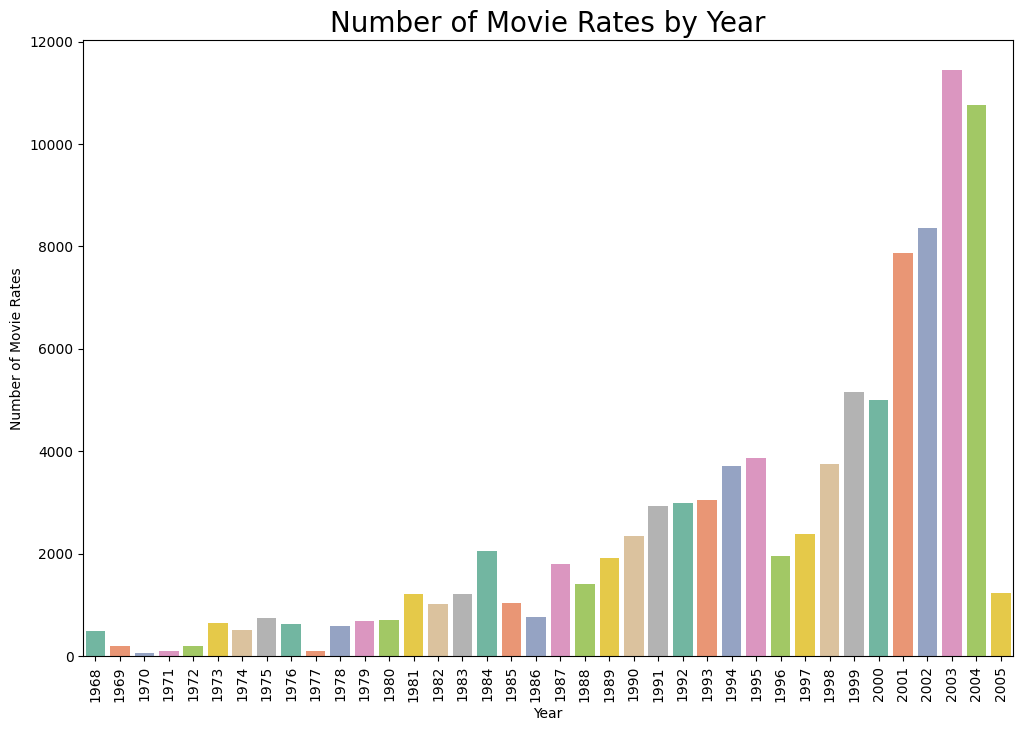

In [11]:
# Number of movies by year visualization

# Group by year and count the number of movies after 1968- we took after 1968 because before 1968 they are less information...
# ...about movies.
number_of_movies_by_year = users_who_rate.filter(users_who_rate['Year'] >= 1968).groupby('Year').count().orderBy('Year')

# convert pyspark data frame to pandas data frame for plotting with seaborn-because seaborn runs with pandas dataframe
number_of_movies_by_year_pandas = number_of_movies_by_year.toPandas()

plt.figure(figsize = (12, 8))
sns.barplot(x = 'Year', y = 'count', data = number_of_movies_by_year_pandas, palette = 'Set2')
plt.title('Number of Movie Rates by Year', size = 20)
plt.xlabel('Year')
plt.xticks(rotation = 90)
plt.ylabel('Number of Movie Rates')
plt.show()

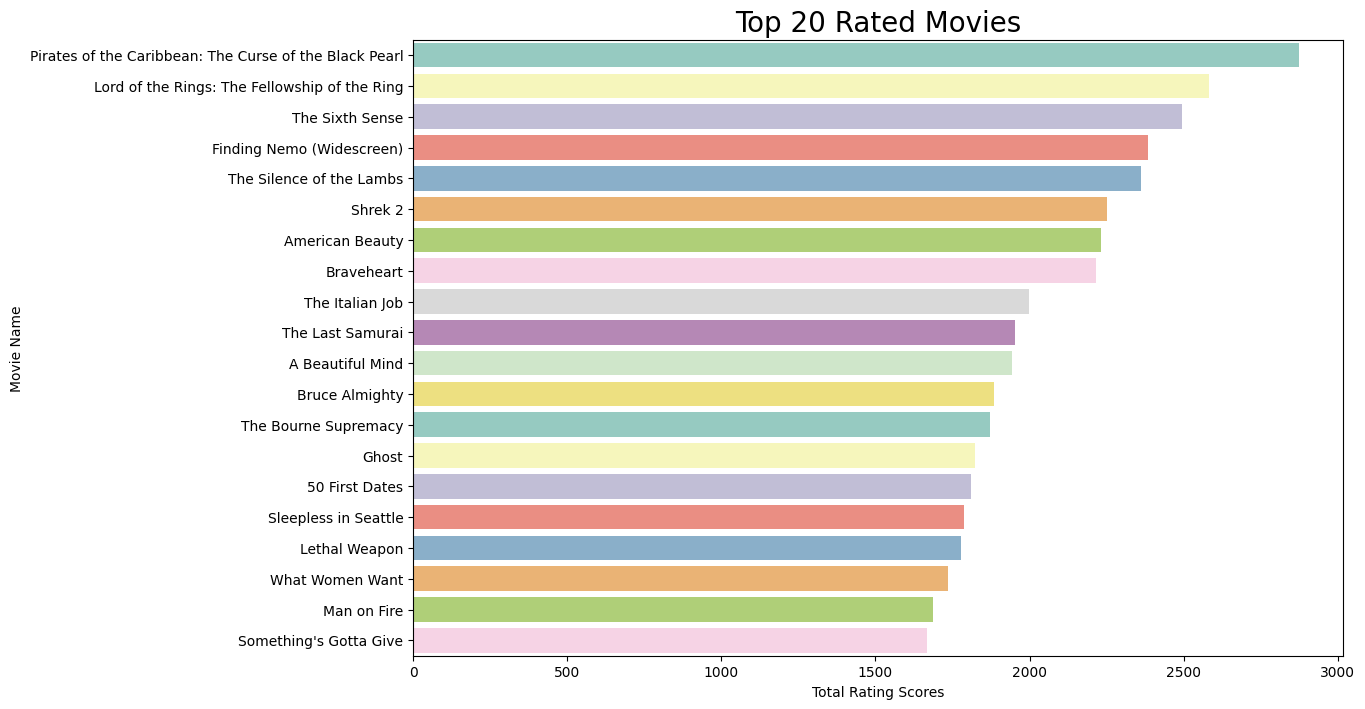

In [12]:
# Group by movie name and sum user ratings
movie_rating_distribution = users_who_rate.groupby('Name').sum('Rating')

# Convert to pandas dataframe and sort by the sum of user ratings
movie_rating_distribution_pandas = movie_rating_distribution.toPandas().sort_values(by = 'sum(Rating)', ascending = False)[:20]

plt.figure(figsize = (12, 8))
sns.barplot(x = 'sum(Rating)', y = 'Name', data = movie_rating_distribution_pandas, palette = 'Set3')
plt.title('Top 20 Rated Movies', size = 20)
plt.xlabel('Total Rating Scores')
plt.ylabel('Movie Name')
plt.show()

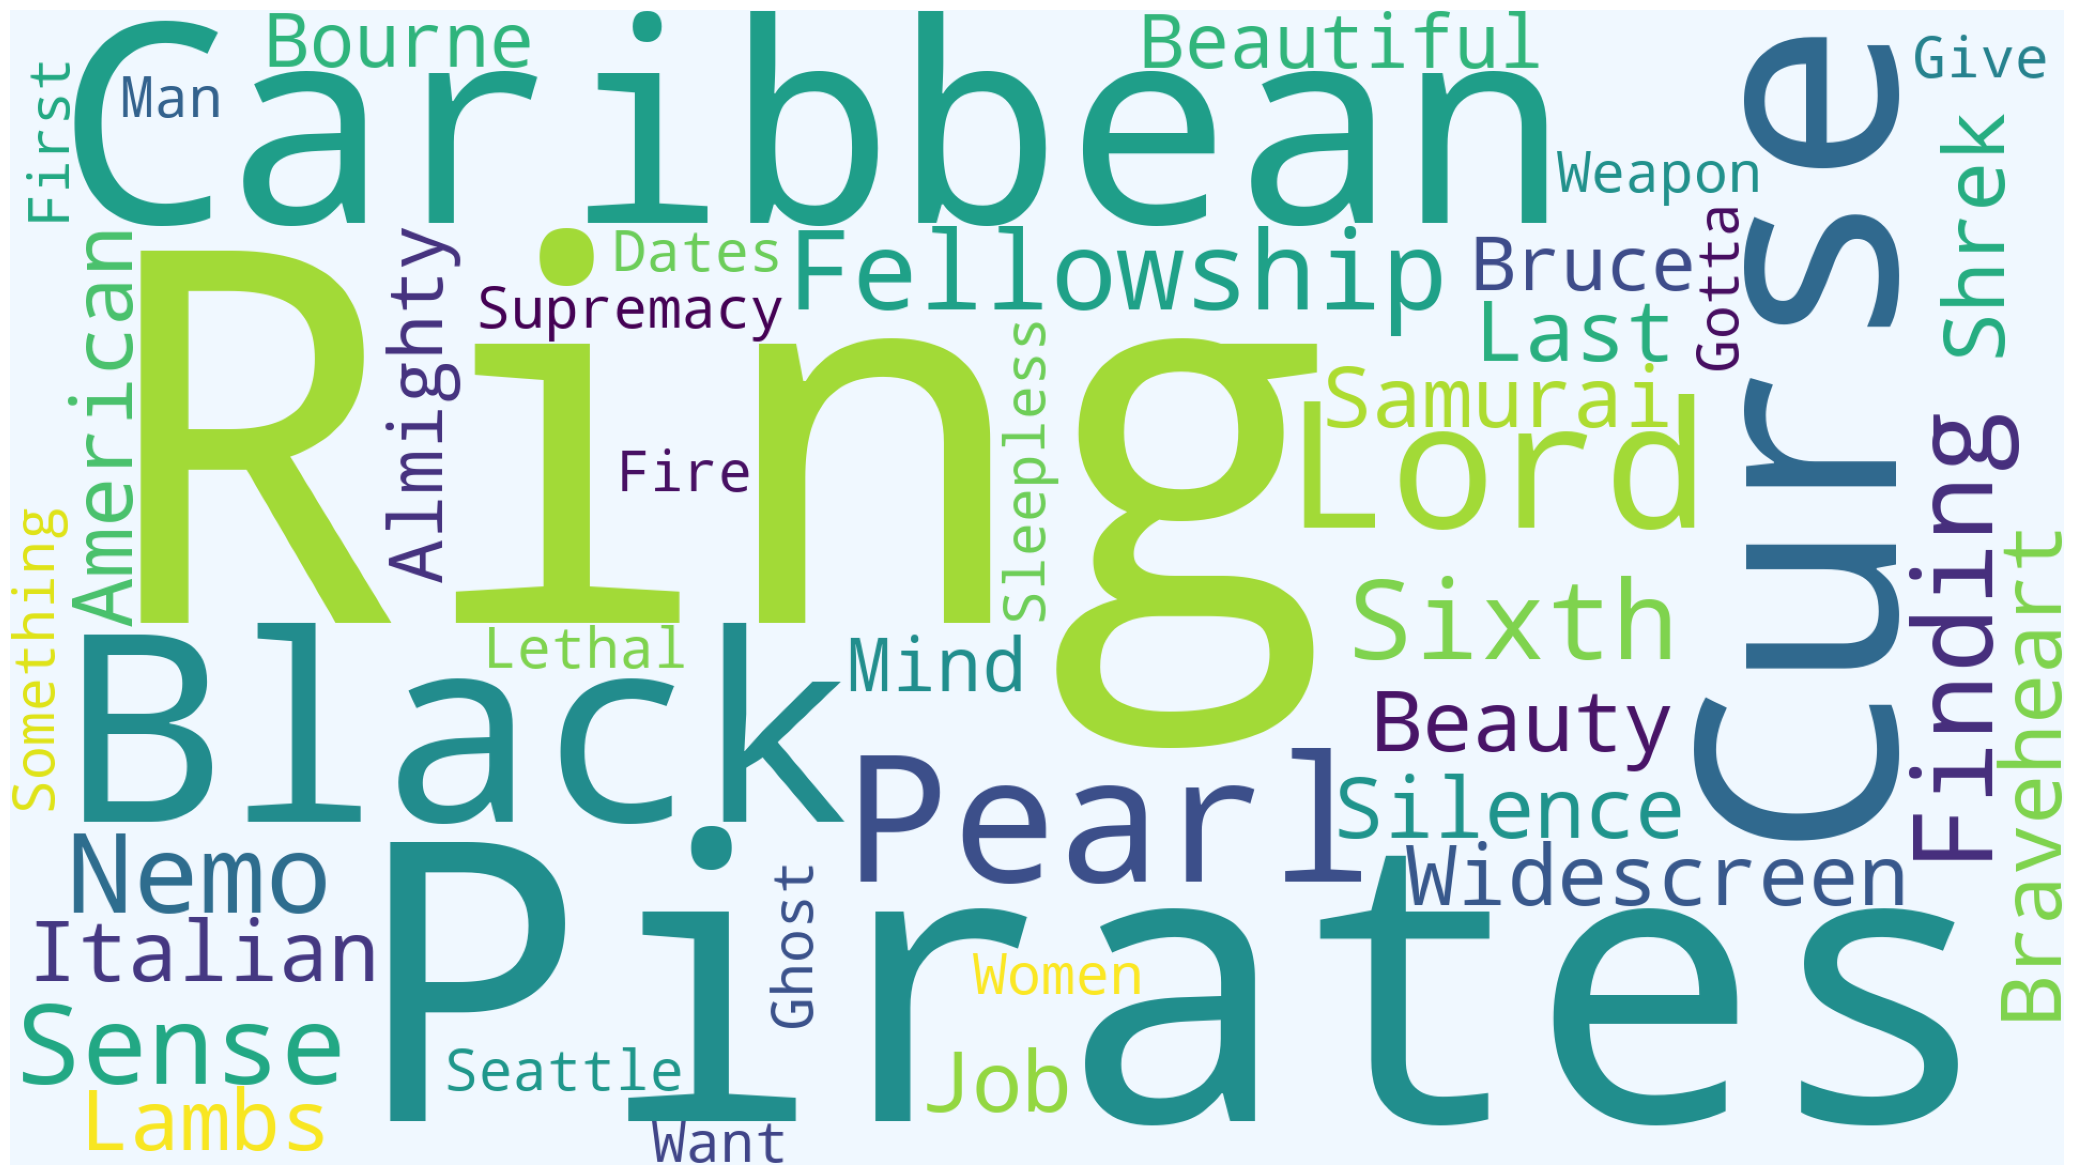

In [13]:
from wordcloud import WordCloud

# The more frequent a movie name appears in the column, the larger its representation in the word cloud and...
# ...generate() method is called with the concatenated string of movie names as input.
plt.subplots(figsize=(30, 15))
wordcloud = WordCloud(background_color='aliceblue', width=1920, height=1080).generate(" ".join(movie_rating_distribution_pandas['Name']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
# recommendation engine

# use %70 of dataset for training, rest of them for testing
# randomly selected rows from users_who_rate_for_prediction with reference of seed
# data will split in the same way every time with same seed (use seed for consistent results)
# In our program seed gives to each of our group members, different training dataset partition and different test dataset partition
train_data, test_data = users_who_rate.randomSplit([0.7, 0.3], seed = 5060)

In [15]:
# train data total row count
print('Train data total row count: ', train_data.count())

print()

train_data = train_data.orderBy('User_ID', ascending = True)
train_data.show(200, truncate = True)

Train data total row count:  69896

+--------+--------------------+----+-------+------+
|Movie_ID|                Name|Year|User_ID|Rating|
+--------+--------------------+----+-------+------+
|     173| The Devil's Brigade|1968|      6|   4.0|
|    1428|         The Recruit|2003|      6|   4.0|
|     564|          Predator 2|1990|      6|   4.0|
|    1571|         Poltergeist|1982|      6|   4.0|
|     723|           Curly Sue|1991|      6|   3.0|
|     825| Bill Cosby: Himself|1983|      6|   3.0|
|     872|       Seven Samurai|1954|      6|   3.0|
|     191|    X2: X-Men United|2003|      6|   2.0|
|     985|           The Mummy|1999|      6|   4.0|
|    1096|       Harlem Nights|1989|      6|   3.0|
|    1144|Fried Green Tomatoes|1991|      6|   2.0|
|    1180|    A Beautiful Mind|2001|      6|   3.0|
|     241|  North by Northwest|1959|      6|   3.0|
|    1267|      Dr. Dolittle 2|2001|      6|   3.0|
|    1314|   Presumed Innocent|1990|      6|   3.0|
|    1399|                19

In [16]:
# test data total row count
print('Test data total row count: ', test_data.count())

print()

test_data = test_data.orderBy('User_ID', ascending = True)
test_data.show(200, truncate = True)

Test data total row count:  30104

+--------+--------------------+----+-------+------+
|Movie_ID|                Name|Year|User_ID|Rating|
+--------+--------------------+----+-------+------+
|     494|Monty Python's Th...|1983|      6|   3.0|
|    2778|Pink Floyd: Live ...|1974|      6|   3.0|
|    1307|            S.W.A.T.|2003|      6|   1.0|
|    2851|        Falling Down|1993|      6|   4.0|
|    2865|Going My Way / Ho...|1944|      6|   3.0|
|     705|        Major League|1989|      6|   3.0|
|    1615|The American Pres...|1995|      6|   4.0|
|    2913|   Finding Neverland|2004|      6|   3.0|
|    3151|   Napoleon Dynamite|2004|      6|   1.0|
|    1659|      Grumpy Old Men|1993|      6|   3.0|
|    3198|   The Addams Family|1991|      6|   3.0|
|    3269|     The Longest Day|1962|      6|   4.0|
|     788|              Clerks|1994|      6|   3.0|
|    1765|           First Kid|1996|      6|   3.0|
|    3315|  The Maltese Falcon|1941|      6|   3.0|
|     528|The Hitchhiker's ..

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [18]:
def prediction(rank, maxIter, regParam):
    als = ALS(userCol = 'User_ID', itemCol = 'Movie_ID', ratingCol = 'Rating', seed = 5060, implicitPrefs = False, nonnegative = True, coldStartStrategy = 'drop', rank = rank, maxIter = maxIter, regParam = regParam)
    model = als.fit(train_data)
    predictions = model.transform(test_data)
    predictions = predictions.withColumnRenamed('prediction', 'Prediction')

    rmse_evaluator = RegressionEvaluator(metricName = 'rmse', labelCol = 'Rating', predictionCol = 'Prediction')
    rmse = rmse_evaluator.evaluate(predictions)
    
    mse_evaluator = RegressionEvaluator(metricName = 'mse', labelCol = 'Rating', predictionCol = 'Prediction')
    mse = mse_evaluator.evaluate(predictions)

    return {'model': model, 'predictions': predictions, 'error_results': {'rank': rank, 'iteration': maxIter, 'lambda': regParam, 'RMSE': rmse, 'MSE': mse}}


In [19]:
def add_model_results(result_dict, model_name, error_results):
    result_dict[model_name] = {'RMSE': error_results['RMSE'], 'MSE': error_results['MSE']}

result_dict = {}

In [20]:
model_1_1 = prediction(10, 10, 0.01)

print(model_1_1['error_results'])

print()

model_1_1['predictions'].show(200, truncate=True)

{'rank': 10, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.0045876856386335, 'MSE': 1.009196418136786}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 4.3688083|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 2.8625498|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.5729432|
|     329|               Dogma|1999|  10817|   2.0|  2.771842|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.9972246|
|     788|              Clerks|1994|  10817|   4.0| 3.4493315|
|     894|            The Muse|1999|  10817|   3.0| 2.5353804|
|    1145| The Wedding Planner|2001|  10817|   2.0| 3.0520713|
|    1518|              Casper|1995|  10817|   3.0|  2.968986|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.6184518|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.2739258|
|    1890|     Re

In [21]:
model_name = 'model_1_1'
error_results = model_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [22]:
model_1_2 = prediction(10, 50, 0.01)


print(model_1_2['error_results'])

print()

model_1_2['predictions'].show(200, truncate = True)

{'rank': 10, 'iteration': 50, 'lambda': 0.01, 'RMSE': 1.0198130422995972, 'MSE': 1.04001864124436}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.7894826|
|     290|Harold and Kumar ...|2004|  10817|   3.0|  2.859079|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.4274468|
|     329|               Dogma|1999|  10817|   2.0|  2.846127|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 4.1831203|
|     788|              Clerks|1994|  10817|   4.0| 3.4637084|
|     894|            The Muse|1999|  10817|   3.0| 2.8276613|
|    1145| The Wedding Planner|2001|  10817|   2.0|  2.745309|
|    1518|              Casper|1995|  10817|   3.0| 3.4499533|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  3.785281|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.7358916|
|    1890|     Reg

In [23]:
model_name = 'model_1_2'
error_results = model_1_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [24]:
model_1_3 = prediction(10, 200, 0.01)


print(model_1_3['error_results'])

print()

model_1_3['predictions'].show(200, truncate = True)

{'rank': 10, 'iteration': 200, 'lambda': 0.01, 'RMSE': 1.0143073671886733, 'MSE': 1.028819435133218}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0|  4.226644|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 2.4641917|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.5381248|
|     329|               Dogma|1999|  10817|   2.0|  3.518302|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.9158547|
|     788|              Clerks|1994|  10817|   4.0| 3.3795843|
|     894|            The Muse|1999|  10817|   3.0| 2.2850635|
|    1145| The Wedding Planner|2001|  10817|   2.0|  2.565672|
|    1518|              Casper|1995|  10817|   3.0|  2.296527|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  3.628574|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 4.8862944|
|    1890|     R

In [25]:
model_name = 'model_1_3'

error_results = model_1_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [26]:
model_2_1 = prediction(50, 10, 0.01)


print(model_2_1['error_results'])

print()

model_2_1['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.0849141137157927, 'MSE': 1.1770386341397239}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.8202891|
|     290|Harold and Kumar ...|2004|  10817|   3.0|  3.895399|
|     313|      Pay It Forward|2000|  10817|   4.0| 2.3032784|
|     329|               Dogma|1999|  10817|   2.0| 3.4962196|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 5.0877275|
|     788|              Clerks|1994|  10817|   4.0| 3.4562714|
|     894|            The Muse|1999|  10817|   3.0|  2.464471|
|    1145| The Wedding Planner|2001|  10817|   2.0|  4.213056|
|    1518|              Casper|1995|  10817|   3.0| 3.1640484|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  4.191701|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 4.4559503|
|    1890|     R

In [27]:
model_name = 'model_2_1'
error_results = model_2_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [28]:
model_2_2 = prediction(50, 50, 0.01)


print(model_2_2['error_results'])

print()

model_2_2['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 50, 'lambda': 0.01, 'RMSE': 1.1053923948776032, 'MSE': 1.2218923466532432}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 4.3563924|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.7369232|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.7981598|
|     329|               Dogma|1999|  10817|   2.0|  4.197519|
|     711|   Dolores Claiborne|1994|  10817|   4.0|  5.024839|
|     788|              Clerks|1994|  10817|   4.0| 3.6533551|
|     894|            The Muse|1999|  10817|   3.0|  3.413527|
|    1145| The Wedding Planner|2001|  10817|   2.0| 3.7971747|
|    1518|              Casper|1995|  10817|   3.0|  2.694037|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.4545166|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 4.7559004|
|    1890|     R

In [29]:
model_name = 'model_2_2'
error_results = model_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [30]:
model_2_3 = prediction(50, 200, 0.01)


print(model_2_3['error_results'])

print()

model_2_3['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 200, 'lambda': 0.01, 'RMSE': 1.1001892102873336, 'MSE': 1.2104162984326667}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.6947744|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.6425297|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.3484766|
|     329|               Dogma|1999|  10817|   2.0|  5.523306|
|     711|   Dolores Claiborne|1994|  10817|   4.0|  5.351546|
|     788|              Clerks|1994|  10817|   4.0|   4.56537|
|     894|            The Muse|1999|  10817|   3.0| 3.0329847|
|    1145| The Wedding Planner|2001|  10817|   2.0| 3.5693858|
|    1518|              Casper|1995|  10817|   3.0| 2.3467357|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  3.103996|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 2.8958683|
|    1890|     

In [31]:
model_name = 'model_2_3'
error_results = model_2_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [32]:
model_3_1 = prediction(200, 10, 0.01)


print(model_3_1['error_results'])

print()

model_3_1['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.0666553634595886, 'MSE': 1.137753664397107}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0|  4.016882|
|     290|Harold and Kumar ...|2004|  10817|   3.0|  3.657796|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.3751972|
|     329|               Dogma|1999|  10817|   2.0| 3.1623788|
|     711|   Dolores Claiborne|1994|  10817|   4.0|  4.008266|
|     788|              Clerks|1994|  10817|   4.0|  2.990861|
|     894|            The Muse|1999|  10817|   3.0|  2.285019|
|    1145| The Wedding Planner|2001|  10817|   2.0| 3.1666343|
|    1518|              Casper|1995|  10817|   3.0| 3.4379718|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  4.211816|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.3956385|
|    1890|     R

In [33]:
model_name = 'model_3_1'
error_results = model_3_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [34]:
model_3_2 = prediction(200, 50, 0.01)


print(model_3_2['error_results'])

print()

model_3_2['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 50, 'lambda': 0.01, 'RMSE': 0.9786717621896345, 'MSE': 0.9577984181073645}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0|  4.052496|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.5194259|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.2441828|
|     329|               Dogma|1999|  10817|   2.0|   3.24445|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6780298|
|     788|              Clerks|1994|  10817|   4.0|  3.626723|
|     894|            The Muse|1999|  10817|   3.0| 2.6702216|
|    1145| The Wedding Planner|2001|  10817|   2.0|  3.484544|
|    1518|              Casper|1995|  10817|   3.0| 3.3980532|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.7134008|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.4142568|
|    1890|     

In [35]:
model_name = 'model_3_2'
error_results = model_3_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [36]:
model_3_3 = prediction(200, 200, 0.01)

print(model_3_3['error_results'])

print()

model_3_3['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 200, 'lambda': 0.01, 'RMSE': 0.9366322843236219, 'MSE': 0.8772800360372861}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 4.0959153|
|     290|Harold and Kumar ...|2004|  10817|   3.0|  3.846352|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1474292|
|     329|               Dogma|1999|  10817|   2.0| 3.3703566|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.8914628|
|     788|              Clerks|1994|  10817|   4.0| 3.4556608|
|     894|            The Muse|1999|  10817|   3.0|  2.612753|
|    1145| The Wedding Planner|2001|  10817|   2.0| 3.3046818|
|    1518|              Casper|1995|  10817|   3.0|  2.896347|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.9241312|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.0579164|
|    1890|    

In [37]:
model_name = 'model_3_3'
error_results = model_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [38]:
model_1_1_1 = prediction(10, 10, 0.1)

print(model_1_1_1['error_results'])

print()

model_1_1_1['predictions'].show(500, truncate = True)

{'rank': 10, 'iteration': 10, 'lambda': 0.1, 'RMSE': 0.8936717721171537, 'MSE': 0.7986492362790139}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 4.0626836|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.2395298|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.5576184|
|     329|               Dogma|1999|  10817|   2.0|  3.327122|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.5414777|
|     788|              Clerks|1994|  10817|   4.0|  3.554119|
|     894|            The Muse|1999|  10817|   3.0| 2.3722148|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7490075|
|    1518|              Casper|1995|  10817|   3.0| 3.0990815|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|   3.43458|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.6378531|
|    1890|     Re

In [39]:
model_name = 'model_1_1_1'
error_results = model_1_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [40]:
model_1_2_2 = prediction(10, 50, 0.1)


print(model_1_2_2['error_results'])

print()

model_1_2_2['predictions'].show(200, truncate = True)

{'rank': 10, 'iteration': 50, 'lambda': 0.1, 'RMSE': 0.8907958355853712, 'MSE': 0.7935172206962396}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.8576984|
|     290|Harold and Kumar ...|2004|  10817|   3.0|  3.290703|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.3391597|
|     329|               Dogma|1999|  10817|   2.0|  3.365882|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6545074|
|     788|              Clerks|1994|  10817|   4.0| 3.4488037|
|     894|            The Muse|1999|  10817|   3.0| 2.4892948|
|    1145| The Wedding Planner|2001|  10817|   2.0|  2.696762|
|    1518|              Casper|1995|  10817|   3.0| 3.1019714|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.5785036|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.7936661|
|    1890|     Re

In [41]:
model_name = 'model_1_2_2'
error_results = model_1_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [42]:
model_1_3_3 = prediction(10, 200, 0.1)


print(model_1_3_3['error_results'])

print()

model_1_3_3['predictions'].show(200, truncate = True)

{'rank': 10, 'iteration': 200, 'lambda': 0.1, 'RMSE': 0.8913593360052974, 'MSE': 0.7945214658838046}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.9516964|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.3183997|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.2895687|
|     329|               Dogma|1999|  10817|   2.0| 3.4346042|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6269522|
|     788|              Clerks|1994|  10817|   4.0| 3.5724897|
|     894|            The Muse|1999|  10817|   3.0| 2.4206462|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7731502|
|    1518|              Casper|1995|  10817|   3.0| 3.1283143|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.5585349|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.6733527|
|    1890|     R

In [43]:
model_name = 'model_1_3_3'
error_results = model_1_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [44]:
model_2_1_1 = prediction(50, 10, 0.1)


print(model_2_1_1['error_results'])

print()

model_2_1_1['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 10, 'lambda': 0.1, 'RMSE': 0.8906380944754428, 'MSE': 0.7932362153308479}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.9387584|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.5411947|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.3082483|
|     329|               Dogma|1999|  10817|   2.0| 3.4086063|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.5693526|
|     788|              Clerks|1994|  10817|   4.0| 3.7527764|
|     894|            The Muse|1999|  10817|   3.0| 2.5897007|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.8471036|
|    1518|              Casper|1995|  10817|   3.0|  3.113336|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  3.637542|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.2776895|
|    1890|     Re

In [45]:
model_name = 'model_2_1_1'
error_results = model_2_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [46]:
model_2_2_2 = prediction(50, 50, 0.1)


print(model_2_2_2['error_results'])

print()

model_2_2_2['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 50, 'lambda': 0.1, 'RMSE': 0.8881766527635963, 'MSE': 0.7888577665143459}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.9948952|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.5282624|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1156542|
|     329|               Dogma|1999|  10817|   2.0| 3.3423383|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6472912|
|     788|              Clerks|1994|  10817|   4.0| 3.5662675|
|     894|            The Muse|1999|  10817|   3.0|  2.553169|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7776153|
|    1518|              Casper|1995|  10817|   3.0| 3.0450437|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.5912375|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 2.9902885|
|    1890|     Re

In [47]:
model_name = 'model_2_2_2'
error_results = model_2_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [48]:
model_2_3_3 = prediction(50, 200, 0.1)


print(model_2_3_3['error_results'])

print()

model_2_3_3['predictions'].show(200, truncate = True)

{'rank': 50, 'iteration': 200, 'lambda': 0.1, 'RMSE': 0.8882313130440819, 'MSE': 0.7889548654720138}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.9739935|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.5163512|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1240149|
|     329|               Dogma|1999|  10817|   2.0| 3.2623458|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6194355|
|     788|              Clerks|1994|  10817|   4.0|  3.533058|
|     894|            The Muse|1999|  10817|   3.0|  2.594045|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.8280015|
|    1518|              Casper|1995|  10817|   3.0| 3.0720766|
|    1703|Ever After: A Cin...|1998|  10817|   3.0|  3.594473|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0|  3.067717|
|    1890|     R

In [49]:
model_name = 'model_2_3_3'
error_results = model_2_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [50]:
model_3_1_1 = prediction(200, 10, 0.1)


print(model_3_1_1['error_results'])

print()

model_3_1_1['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 10, 'lambda': 0.1, 'RMSE': 0.8889264349863393, 'MSE': 0.7901902068175225}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.8360775|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.4209416|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1425235|
|     329|               Dogma|1999|  10817|   2.0|    3.2193|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.4892325|
|     788|              Clerks|1994|  10817|   4.0| 3.5675728|
|     894|            The Muse|1999|  10817|   3.0| 2.6428778|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7114985|
|    1518|              Casper|1995|  10817|   3.0|   3.15453|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.5816846|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.0440338|
|    1890|     R

In [51]:
model_name = 'model_3_1_1'
error_results = model_3_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

In [52]:
model_3_2_2 = prediction(200, 50, 0.1)


print(model_3_2_2['error_results'])

print()

model_3_2_2['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 50, 'lambda': 0.1, 'RMSE': 0.8873260702391976, 'MSE': 0.7873475549261375}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.8553882|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.4347827|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1734633|
|     329|               Dogma|1999|  10817|   2.0| 3.2264974|
|     711|   Dolores Claiborne|1994|  10817|   4.0| 3.6080196|
|     788|              Clerks|1994|  10817|   4.0| 3.5570154|
|     894|            The Muse|1999|  10817|   3.0| 2.5189831|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7574766|
|    1518|              Casper|1995|  10817|   3.0| 3.1571176|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.6183164|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.1586483|
|    1890|     R

In [53]:
model_name = 'model_3_2_2'
error_results = model_3_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

In [54]:
model_3_3_3 = prediction(200, 200, 0.1)


print(model_3_3_3['error_results'])

print()

model_3_3_3['predictions'].show(200, truncate = True)

{'rank': 200, 'iteration': 200, 'lambda': 0.1, 'RMSE': 0.8873214709206377, 'MSE': 0.7873393927567641}

+--------+--------------------+----+-------+------+----------+
|Movie_ID|                Name|Year|User_ID|Rating|Prediction|
+--------+--------------------+----+-------+------+----------+
|     175|      Reservoir Dogs|1992|  10817|   4.0| 3.8632188|
|     290|Harold and Kumar ...|2004|  10817|   3.0| 3.4678986|
|     313|      Pay It Forward|2000|  10817|   4.0| 3.1704252|
|     329|               Dogma|1999|  10817|   2.0|  3.239073|
|     711|   Dolores Claiborne|1994|  10817|   4.0|    3.6152|
|     788|              Clerks|1994|  10817|   4.0| 3.5478413|
|     894|            The Muse|1999|  10817|   3.0| 2.5262213|
|    1145| The Wedding Planner|2001|  10817|   2.0| 2.7715385|
|    1518|              Casper|1995|  10817|   3.0|  3.118801|
|    1703|Ever After: A Cin...|1998|  10817|   3.0| 3.5995414|
|    1865|Eternal Sunshine ...|2004|   6336|   1.0| 3.1053677|
|    1890|     

In [55]:
model_name = 'model_3_3_3'
error_results = model_3_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

In [56]:
error_results = []

In [57]:
error_results.append(model_1_1['error_results'])
error_results.append(model_1_2['error_results'])
error_results.append(model_1_3['error_results'])
error_results.append(model_2_1['error_results'])
error_results.append(model_2_2['error_results'])
error_results.append(model_2_3['error_results'])
error_results.append(model_3_1['error_results'])
error_results.append(model_3_2['error_results'])
error_results.append(model_3_3['error_results'])

error_results.append(model_1_1_1['error_results'])
error_results.append(model_1_2_2['error_results'])
error_results.append(model_1_3_3['error_results'])
error_results.append(model_2_1_1['error_results'])
error_results.append(model_2_2_2['error_results'])
error_results.append(model_2_3_3['error_results'])
error_results.append(model_3_1_1['error_results'])
error_results.append(model_3_2_2['error_results'])
error_results.append(model_3_3_3['error_results'])

error_results_data_frame = spark.createDataFrame(error_results)
error_results_data_frame.show(200, truncate = True)

+------------------+------------------+---------+------+----+
|               MSE|              RMSE|iteration|lambda|rank|
+------------------+------------------+---------+------+----+
| 1.009196418136786|1.0045876856386335|       10|  0.01|  10|
|  1.04001864124436|1.0198130422995972|       50|  0.01|  10|
| 1.028819435133218|1.0143073671886733|      200|  0.01|  10|
|1.1770386341397239|1.0849141137157927|       10|  0.01|  50|
|1.2218923466532432|1.1053923948776032|       50|  0.01|  50|
|1.2104162984326667|1.1001892102873336|      200|  0.01|  50|
| 1.137753664397107|1.0666553634595886|       10|  0.01| 200|
|0.9577984181073645|0.9786717621896345|       50|  0.01| 200|
|0.8772800360372861|0.9366322843236219|      200|  0.01| 200|
|0.7986492362790139|0.8936717721171537|       10|   0.1|  10|
|0.7935172206962396|0.8907958355853712|       50|   0.1|  10|
|0.7945214658838046|0.8913593360052974|      200|   0.1|  10|
|0.7932362153308479|0.8906380944754428|       10|   0.1|  50|
|0.78885

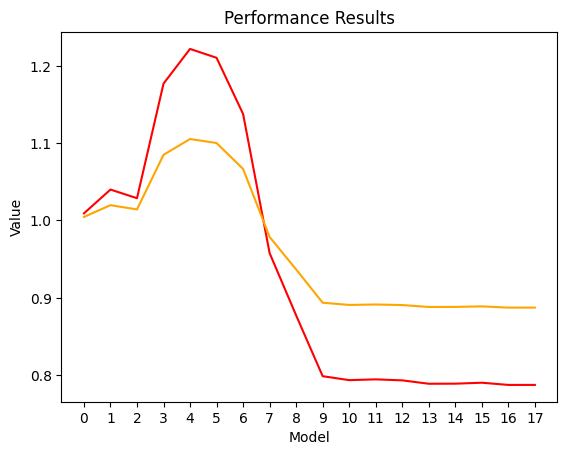

<Figure size 1200x800 with 0 Axes>

In [58]:
# convert pyspark data frame to pandas data frame - dataframe conversion in order to create plot
error_results_pandas = error_results_data_frame.toPandas()

# Plot MSE and RMSE
plt.plot(error_results_pandas.index, error_results_pandas['MSE'], linestyle='-', color = 'red', label = 'MSE')
plt.plot(error_results_pandas.index, error_results_pandas['RMSE'], linestyle='-', color = 'orange', label = 'RMSE')

# plt.plot(error_results_pandas.index, error_results_pandas['rank'], linestyle='--', color = 'purple', label = 'Rank')
# plt.plot(error_results_pandas.index, error_results_pandas['iteration'], linestyle='--', color = 'black', label = 'Iteration')
# plt.plot(error_results_pandas.index, error_results_pandas['lambda'], linestyle='--', color = 'brown', label = 'Lambda')

plt.xlabel('Model')
plt.xticks(error_results_pandas.index.astype(int))
plt.ylabel('Value')
plt.title('Performance Results')
plt.figure(figsize = (12, 8))
plt.show()

In [59]:
model_listesi = ['model_1_1', 'model_1_2', 'model_1_3', 'model_2_1', 'model_2_2', 'model_2_3', 'model_3_1', 'model_3_2', 'model_3_3', 'model_1_1_1', 'model_1_2_2', 'model_1_3_3', 'model_2_1_1', 'model_2_2_2', 'model_2_3_3', 'model_3_1_1', 'model_3_2_2', 'model_3_3_3']

best_rmse = float('inf')
best_mse = float('inf')
best_result_index = None

for i, model in enumerate(model_listesi):
    result = result_dict[model]
    rmse = result['RMSE']
    mse = result['MSE']

    if rmse <= best_rmse and mse <= best_mse:
        best_rmse = rmse
        best_mse = mse
        best_result_index = i

best_model = model_listesi[best_result_index]

print('Best model based on RMSE and MSE:', result_dict[best_model])
print(f'Best model is: {best_model}', "\n")
print("The best model is selected based on having the lowest RMSE or MSE, as these indicate the model's ability to minimize prediction errors. Lower values suggest that the model's predictions are closer to the actual values, resulting in better overall performance.")

Best model based on RMSE and MSE: {'RMSE': 0.8873214709206377, 'MSE': 0.7873393927567641}
Best model is: model_3_3_3 

The best model is selected based on having the lowest RMSE or MSE, as these indicate the model's ability to minimize prediction errors. Lower values suggest that the model's predictions are closer to the actual values, resulting in better overall performance.


In [60]:
if best_model in globals():
    my_dict = globals()[best_model]

In [61]:
from pyspark.sql import Row
from numpy import linalg as LA
from pyspark.sql import functions as F
import numpy as np

best_model_item_factors = my_dict['model'].itemFactors

movie_id = 1843
other_movies = []

selected_movie = best_model_item_factors.where(best_model_item_factors.id == movie_id).select('features')

selected_movie_features = selected_movie.rdd.map(lambda x: x.features).first()

for row in best_model_item_factors.rdd.toLocalIterator():
    if row.id != movie_id:
        v1 = np.asarray(row.features)
        v2 = np.asarray(selected_movie_features)
        similarity_score = v1.dot(v2) / (LA.norm(v1) * LA.norm(v2))
        other_movies.append([row.id, similarity_score])
R = Row('Movie_ID', 'Similarity_Score')

similar_items_dataframe = spark.createDataFrame([R(column[0], float(column[1])) for column in other_movies])

similarity_sum_rdd = similar_items_dataframe.rdd.map(lambda x: (x['Movie_ID'], x['Similarity_Score'])).reduceByKey(lambda a, b: a + b)

R = Row('Movie_ID', 'Similarity_Sum')
similarity_sum_dataframe = spark.createDataFrame([R(movie_id, similarity_sum) for movie_id, similarity_sum in similarity_sum_rdd.collect()])

In [62]:
# Select the top 10 movies by similarity sum
top_ten_movies = similarity_sum_dataframe.orderBy(similarity_sum_dataframe.Similarity_Sum.desc()).limit(10)
# Show the top 10 movies
top_ten_movies.show()

+--------+------------------+
|Movie_ID|    Similarity_Sum|
+--------+------------------+
|    3610|0.8552765704690432|
|    2847|0.8541712056943017|
|    3433|0.8442556450520939|
|    2908|0.8417494816967046|
|    2980|0.8373425982998871|
|     341|0.8346639027638963|
|    3077|0.8337250409594039|
|    1578|0.8291716384157622|
|    4168|0.8267320098874966|
|     166|0.8265259002848002|
+--------+------------------+



In [63]:
# Returns list
top_ten_movie_ids = top_ten_movies.rdd.map(lambda x: x.Movie_ID).collect()

In [64]:
users_who_rated_selected_movie = my_dict['predictions'].filter(my_dict['predictions'].Movie_ID == movie_id)
user_ids_who_rated_selected_movie = users_who_rated_selected_movie.select("User_ID").rdd.flatMap(lambda x: x).collect()
users_without_rated_selected_movie = my_dict['predictions'].filter(~my_dict['predictions'].User_ID.isin(user_ids_who_rated_selected_movie))

In [65]:
recommended_users = []
for new_movie_id in top_ten_movie_ids:
    recommended_selected_movie = my_dict['predictions'].filter(my_dict['predictions'].Movie_ID == new_movie_id)
    sorted_ratings = recommended_selected_movie.sort(F.desc('Rating'))
    users_who_like_selected_movie = sorted_ratings.select('User_ID').limit(10)
    users_who_like_selected_movie_ids = users_who_like_selected_movie.rdd.map(lambda x: x.User_ID).collect()
    recommended_users.append({'Movie_ID': new_movie_id, 'User_ID': users_who_like_selected_movie_ids})

recommended_dataframe = spark.createDataFrame(recommended_users)
recommended_dataframe.show()

+--------+--------------------+
|Movie_ID|             User_ID|
+--------+--------------------+
|    3610|[8588, 14189, 981...|
|    2847|[1897, 4247, 1131...|
|    3433|[14833, 5827, 881...|
|    2908|[10374, 12876, 13...|
|    2980|              [3432]|
|     341|        [8815, 3589]|
|    3077|[7063, 8092, 1026...|
|    1578|[9691, 9850, 7, 3...|
|    4168|[4638, 12477, 132...|
|     166|[3998, 4422, 9399...|
+--------+--------------------+



In [66]:
first_row = recommended_dataframe.first()
top_users_like_count = 10

users_who_like_selected_movie = first_row["User_ID"]
remaining_user_count = top_users_like_count - len(users_who_like_selected_movie)

if remaining_user_count > 0:
    rows_to_consider = recommended_dataframe.take(remaining_user_count)[1:]
    for row in rows_to_consider:
        users_who_like_selected_movie.extend(row["User_ID"])
        remaining_user_count = top_users_like_count - len(users_who_like_selected_movie)
        if remaining_user_count <= 0:
            break

if len(users_who_like_selected_movie) > top_users_like_count:
    users_who_like_selected_movie = users_who_like_selected_movie[:top_users_like_count]

print(f"Recommended top 10 users for the movie {movie_id}: ", users_who_like_selected_movie)

Recommended top 10 users for the movie 1843:  [8588, 14189, 9816, 8815, 10943, 3764, 14060, 6177, 5727, 11138]
